In [1]:
import re
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
#importing the datasets
movies=pd.read_csv('movies.csv')
movies=movies.drop(['genres'],axis='columns')

In [4]:
ratings=pd.read_csv('ratings.csv')
ratings=ratings.drop(['timestamp'],axis='columns')

In [5]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
ratings['rating'].sort_values().unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
dtypes: int64(1), object(1)
memory usage: 152.3+ KB


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [10]:
ratings['userId'].nunique()

610

In [12]:
#setting thresholds
popular_movies_thresh=25
active_user_thresh=100

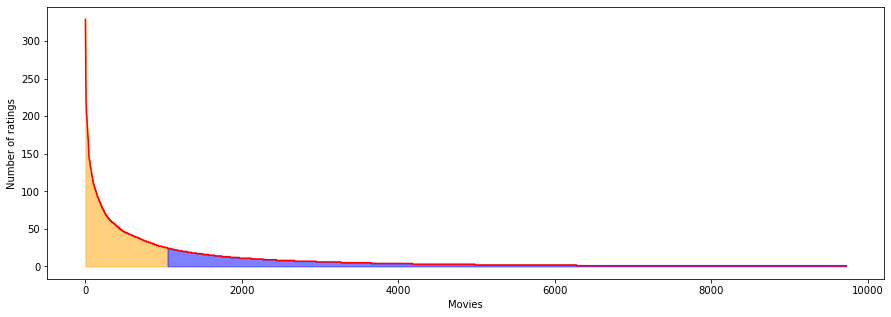

In [14]:
movies_count= pd.DataFrame(ratings.groupby('movieId').size().sort_values(ascending=False), columns=['count'])
divider=len(movies_count.query('count>= @popular_movies_thresh'))
fig,(ax)=plt.subplots(1,1,figsize=(15,5))
plt.plot(np.arange(len(movies_count)), movies_count['count'],color='red')
plt.xlabel('Movies')
plt.ylabel('Number of ratings')
ax.fill_between(np.arange(0,divider), movies_count['count'][:divider],color='orange',alpha=0.5)
ax.fill_between(np.arange(divider,len(movies_count)), movies_count['count'][divider:],color='blue',alpha=0.5)

In [15]:
#removing unpopular_movies
popular_movies_indices= movies_count.query('count>= @popular_movies_thresh').index
popular_ratings= ratings[ratings['movieId'].isin(popular_movies_indices)]

In [16]:
#number of rows in original ratings data
ratings.shape[0]

100836

In [17]:
#after dropping unpopular
popular_ratings.shape[0]

62518

In [18]:
#movies before dropping
ratings.groupby('movieId').count().shape[0]

9724

In [19]:
#movies after dropping unpopular movies
popular_ratings.groupby('movieId').count().shape[0]

1050

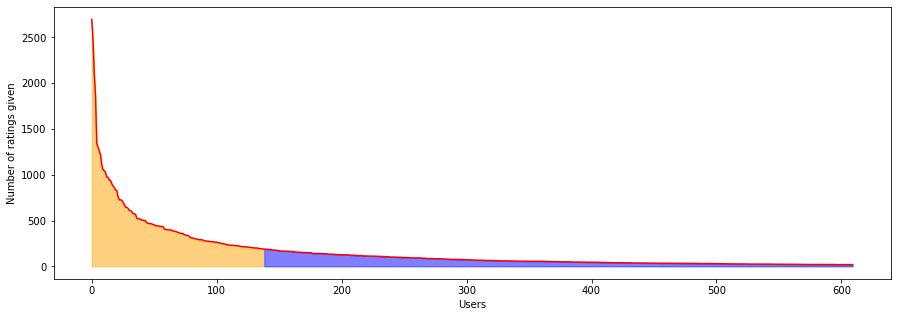

In [22]:
#long tail processing for active users
users_count= pd.DataFrame(ratings.groupby('userId').size().sort_values(ascending=False), columns=['count'])
divider=len(movies_count.query('count>= @active_user_thresh'))
fig,(ax)=plt.subplots(1,1,figsize=(15,5))
plt.plot(np.arange(len(users_count)), users_count['count'],color='red')
plt.xlabel('Users')
plt.ylabel('Number of ratings given')
ax.fill_between(np.arange(0,divider), users_count['count'][:divider],color='orange',alpha=0.5)
ax.fill_between(np.arange(divider,len(users_count)), users_count['count'][divider:],color='blue',alpha=0.5)

In [24]:
 #removing unpopular_movies
active_users_indices= users_count.query('count>= @active_user_thresh').index
active_users_ratings= popular_ratings[popular_ratings['userId'].isin(active_users_indices)]

In [26]:
#before dropping
popular_ratings.shape[0]

62518

In [27]:
active_users_ratings.shape[0]

49416

In [29]:
popular_ratings.groupby('userId').count().shape[0]

610

In [30]:
active_users_ratings.groupby('userId').count().shape[0]

248

In [32]:
#creating pivot table containing ratings given by the users
pivot_table=active_users_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [33]:
pivot_table.index.shape[0]

1050

In [34]:
pivot_table.columns.shape[0]

248

In [35]:
pivot_table.head()

userId,1,4,6,7,10,15,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [36]:
#creating a sparse matrix from pivot table
sparse_matrix=csr_matrix(pivot_table.values)

In [37]:
pivot_table_movies= movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id= {movie: i for i, movie in enumerate(pivot_table_movies)}

In [38]:
id_to_title= {v:k for k, v in title_to_id.items()}

In [39]:
model_knn= NearestNeighbors(metric= 'cosine', algorithm= 'brute')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [41]:
#search based on keyword
def find_matches(title_to_id, movie_title):
    movie_ids= np.array(list(title_to_id.values())).astype(int)
    titles= np.array(list(title_to_id.keys()))
    ratios= list()
    for title, movie_id in title_to_id.items():
        ratio= SequenceMatcher(None, movie_title, title, autojunk=False).ratio()
        ratios.append(ratio)
    titles, ids= titles[np.argsort(ratios)][-10:], movie_ids[np.argsort(ratios)][-10:]
    return list(reversed(list(zip(titles, ids))))

In [42]:
title= 'Avengers'
options= find_matches(title_to_id, title)
import ipywidgets as widgets
drop= widgets.Dropdown(options= options)
drop

Dropdown(options=(('Avengers, The (2012)', 995), ('Swingers (1996)', 233), ('Avengers: Age of Ultron (2015)', …

In [45]:
movie_id= drop.value
test= pivot_table.iloc[movie_id, :].values.reshape(1,-1)
distances, indices= model_knn.kneighbors(test, n_neighbors=10 + 1)
indices= indices.squeeze()[1:]
print('Recommendations for : ', id_to_title[movie_id])
for i,index in enumerate(indices):
    print(i+1, '.', id_to_title[index])

Recommendations for :  American Gangster (2007)
1 . Blood Diamond (2006)
2 . 3:10 to Yuma (2007)
3 . Hangover, The (2009)
4 . I Am Legend (2007)
5 . Hurt Locker, The (2008)
6 . American Psycho (2000)
7 . Training Day (2001)
8 . No Country for Old Men (2007)
9 . Lucky Number Slevin (2006)
10 . Departed, The (2006)
